In [1]:
import os
import hdbscan
import debacl
import fastcluster
import sklearn.cluster
import scipy
import scipy.cluster
import sklearn.datasets
import sklearn.metrics
import sklearn.metrics.cluster
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('poster')
sns.set_palette('Paired', 10)
sns.set_color_codes()

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

   os.environ['OMP_NUM_THREADS'] = '1'

In [2]:
def load_file(filename, className):
  script_dir = os.getcwd()
  data_dir = os.path.join(script_dir, '..', 'data')
  file_path = os.path.join(data_dir, filename)

  try:
    data = pd.read_csv(file_path)
    dataOnly = data.drop(className, axis='columns')
    labelsOnly = data[className]

    encoder = LabelEncoder()

    dict = {'Filename': filename,
        'DataOnly': dataOnly,
        'Data': data,
        'LabelsOnly': encoder.fit_transform(labelsOnly),
        'LabelsEncoded': encoder.classes_,
        'LabelsOnlyEncoded': labelsOnly
        }

    return dict
  except FileNotFoundError:
    print(f"Arquivo {filename} não encontrado no diretório {data_dir}")
    return None
  except pd.errors.EmptyDataError:
    print(f"Arquivo {filename} está vazio")
    return None
  except pd.errors.ParserError:
    print(f"Erro ao analisar o arquivo {filename}")
    return None

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          printNumberFormatGraph = '0.4f',
                          printNumberFormatLegend = None):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, ("{:"+printNumberFormatGraph+"}").format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    if(printNumberFormatLegend == None):
      printNumberFormatLegend = printNumberFormatGraph

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel(('Predicted label\naccuracy={:'+printNumberFormatLegend+'}; misclass={:'+printNumberFormatLegend+'}').format(accuracy, misclass))
    #plt.show()
    return plt;

In [3]:
data= load_file("iris.csv", "class")
print(data["Filename"])
#print(data["DataOnly"].head())
#print(data["Data"].head())
#print(data["LabelsOnly"].head())
print(data["LabelsEncoded"])


iris.csv
['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


In [4]:
import numpy as np
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix

def hungarian_algorithm(true_labels, cluster_labels):
    # Compute the cost matrix
    cost_matrix = confusion_matrix(true_labels, cluster_labels)

    # Apply the Hungarian algorithm
    row_ind, col_ind = linear_sum_assignment(-cost_matrix)

    # Reassign clusters based on the optimal assignment
    new_labels = np.zeros_like(cluster_labels)
    for i, j in zip(row_ind, col_ind):
        new_labels[cluster_labels == j] = i

    return new_labels

def hungarian_algorithm_adjusted(true_labels, cluster_labels):
    # Compute the confusion matrix
    cost_matrix = confusion_matrix(true_labels, cluster_labels)

    # Get the number of clusters and classes
    n_clusters = cost_matrix.shape[1]
    n_classes = cost_matrix.shape[0]

    # Determine the size of the extended matrix
    max_size = max(n_clusters, n_classes)

    # Create an extended cost matrix filled with a high cost (e.g., the sum of all costs + 1)
    extended_cost_matrix = np.full((max_size, max_size), fill_value=cost_matrix.sum() + 1)

    # Fill the extended cost matrix with the original cost matrix values
    extended_cost_matrix[:n_classes, :n_clusters] = cost_matrix

    # Apply the Hungarian algorithm to the extended cost matrix
    row_ind, col_ind = linear_sum_assignment(-extended_cost_matrix)

    # Reassign clusters based on the optimal assignment
    new_labels = np.zeros_like(cluster_labels)
    for i, j in zip(row_ind, col_ind):
        if i < n_classes and j < n_clusters:  # Ensure valid mapping
            new_labels[cluster_labels == j] = i

    return new_labels

def hungarian_algorithm_adjusted2(true_labels, cluster_labels):
    # Compute the confusion matrix
    cost_matrix = confusion_matrix(true_labels, cluster_labels)

    # Get the number of clusters and classes
    n_clusters = cost_matrix.shape[1]
    n_classes = cost_matrix.shape[0]

    # Determine the size of the extended matrix
    max_size = max(n_clusters, n_classes)

    # Create an extended cost matrix filled with a high cost (e.g., the sum of all costs + 1)
    extended_cost_matrix = np.full((max_size, max_size), fill_value=cost_matrix.sum() + 1)

    # Fill the extended cost matrix with the original cost matrix values
    extended_cost_matrix[:n_classes, :n_clusters] = cost_matrix

    # Apply the Hungarian algorithm to the extended cost matrix
    row_ind, col_ind = linear_sum_assignment(-extended_cost_matrix)

    # Reassign clusters based on the optimal assignment
    new_labels = np.zeros_like(cluster_labels)

    for i, j in zip(row_ind, col_ind):
        if i < n_classes and j < n_clusters:  # Ensure valid mapping
            new_labels[cluster_labels == j] = i
        elif j >= n_clusters:  # If a dummy cluster is assigned, set it to a new class index
            new_labels[cluster_labels == j] = n_classes + (j - n_clusters)
        elif i >= n_classes:  # If a dummy class is assigned, leave the cluster label as is
            new_labels[cluster_labels == j] = j

    return new_labels

In [8]:
def benchmark_algorithm(datasetName, dataset, cluster_function_name, cluster_function, function_args, function_kwds, sample_size=2):
    start_time = time.time()
    cluster = cluster_function(dataset["DataOnly"], *function_args, **function_kwds)
    time_taken = time.time() - start_time

    labels_ = []

    if(type(cluster).__module__ != np.__name__):
        labels_ = cluster.labels_;
    #else:
    #    labels_ = cluster;

    encoder = LabelEncoder()
    encoder.fit_transform(labels_),
    clusterClasses = encoder.classes_

    contingency = sklearn.metrics.cluster.contingency_matrix(dataset["LabelsOnly"], labels_)

    clusterLabels = labels_.astype("object");

    for idx2, newClusterLabel in enumerate(clusterClasses):
        maxValue = -1;
        maxLabel = "";
        for idx, p in enumerate(dataset['LabelsEncoded']):
            if(contingency[idx][idx2] > maxValue):
                maxValue = contingency[idx][idx2];
                maxLabel = dataset['LabelsEncoded'][idx];
        
        clusterLabels[clusterLabels==newClusterLabel] = maxLabel

    confusion_matrix = sklearn.metrics._classification.confusion_matrix(dataset["LabelsOnlyEncoded"], clusterLabels, normalize='all')
    cmd = plot_confusion_matrix(cm=confusion_matrix,
                                target_names=dataset["LabelsEncoded"],
                                title='Confusion matrix - '+datasetName+' - '+cluster_function_name,
                                printNumberFormatGraph=".0%",
                                printNumberFormatLegend=".1%")
    
    purity_score = np.sum(np.amax(confusion_matrix, axis=0)) / np.sum(confusion_matrix)
    jaccard_score = sklearn.metrics._classification.jaccard_score(dataset["LabelsOnlyEncoded"], clusterLabels, average='micro')
    adjusted_rand_score = sklearn.metrics.cluster.adjusted_rand_score(dataset["LabelsOnlyEncoded"], clusterLabels)
    accuracy_score = sklearn.metrics._classification.accuracy_score(dataset["LabelsOnlyEncoded"], clusterLabels)

    classification_report = sklearn.metrics.classification_report(dataset["LabelsOnlyEncoded"], clusterLabels, target_names=dataset["LabelsEncoded"], zero_division=0)

    result = {'ClusterFunctionName': cluster_function_name,
        'Cluster': cluster,
        'TimeTaken': time_taken,
        'ClusterLabels': clusterLabels,
        'AccuracyScore': accuracy_score,
        'PurityScore': purity_score,
        'AdjustedRandScore': adjusted_rand_score,
        'JaccardScore': jaccard_score,
        #'ContingencyMatrix': contingency,
        'ConfusionMatrix': confusion_matrix,
        'ClassificationReport': classification_report,
        'ConfusionMatrixDisplay': cmd
        }

    return result

Rice Cammeo Osmancik Dataset



Cluster Algorithm: Mean Shift
Time Taken (seg): 49.63379693031311
Accuracy Score: 0.5721784776902887
              precision    recall  f1-score   support

      Cammeo       0.00      0.00      0.00      1630
    Osmancik       0.57      1.00      0.73      2180

    accuracy                           0.57      3810
   macro avg       0.29      0.50      0.36      3810
weighted avg       0.33      0.57      0.42      3810



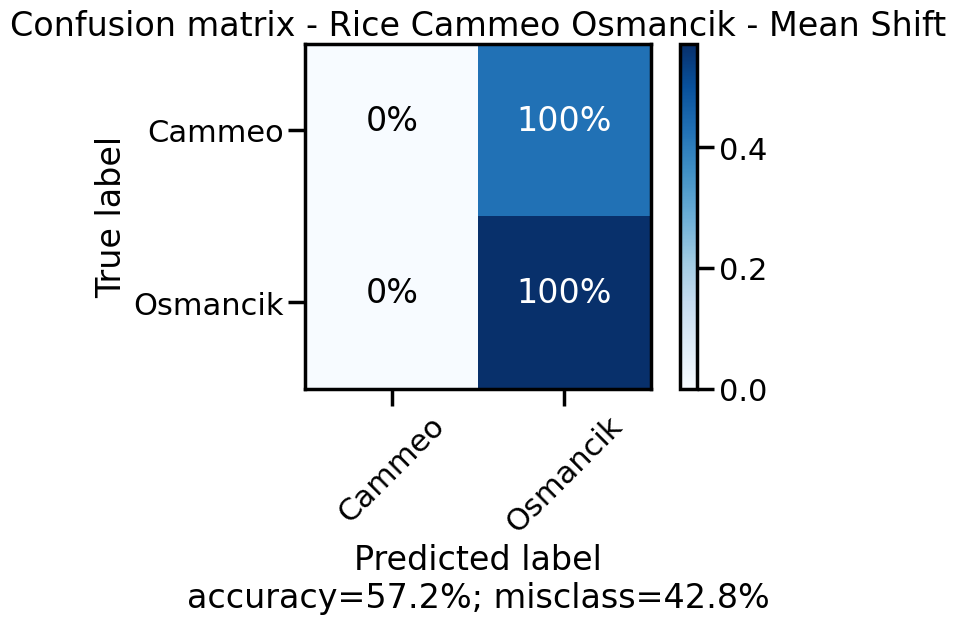

In [9]:
dataList = {
        #'Iris': "iris.csv",
        'Rice Cammeo Osmancik': "Rice_Cammeo_Osmancik.arff.csv"
        }

for dataKey in dataList:
    print(color.BOLD + color.UNDERLINE + dataKey + " Dataset" + color.END + "\n")
    
    data = load_file(dataList[dataKey], "class")

    clusterResult = [];

    '''
    k_means = sklearn.cluster.KMeans(len(data["LabelsEncoded"]), n_init='auto', max_iter=300)
    clusterResult.append(benchmark_algorithm(dataKey, data, "K-means", k_means.fit, (), {}))
    #'''

    '''
    dbscan = sklearn.cluster.DBSCAN(eps=0.1)
    clusterResult.append(benchmark_algorithm(dataKey, data, "DBScan", dbscan.fit, (), {}))
    #'''
    '''
    agglomerative = sklearn.cluster.AgglomerativeClustering(len(data["LabelsEncoded"]))
    clusterResult.append(benchmark_algorithm(dataKey, data, "Agglomerative Clustering", agglomerative.fit, (), {}))
    #'''
    '''
    spectral = sklearn.cluster.SpectralClustering(len(data["LabelsEncoded"]))
    clusterResult.append(benchmark_algorithm(dataKey, data, "Spectral Clustering", spectral.fit, (), {}))
    #'''
    '''
    birch = sklearn.cluster.Birch(n_clusters=len(data["LabelsEncoded"]), threshold=0.3)
    clusterResult.append(benchmark_algorithm(dataKey, data, "Birch", birch.fit, (), {}))
    #'''
    #'''
    meanShift = sklearn.cluster.MeanShift()
    clusterResult.append(benchmark_algorithm(dataKey, data, "Mean Shift", meanShift.fit, (), {}))
    #'''

    '''
    affinity_prop = sklearn.cluster.AffinityPropagation(random_state=5)
    clusterResult.append(benchmark_algorithm(dataKey, data, "Affinity Propagation", affinity_prop.fit, (), {}))
    #'''

    '''
    optics= sklearn.cluster.OPTICS()
    clusterResult.append(benchmark_algorithm(dataKey, data, "OPTICS", optics.fit, (), {}))
    #'''

    #clusterResult.append(benchmark_algorithm(dataKey, data, "Fast Cluster", fastcluster.linkage_vector, (), {}))
    
    #clusterResult.append(benchmark_algorithm(dataKey, data, "Hierarchy", scipy.cluster.hierarchy.single, (), {}))    

    for dataResult in clusterResult:
        print(color.UNDERLINE + "Cluster Algorithm: " + dataResult['ClusterFunctionName'] + color.END)
        print("Time Taken (seg):", dataResult['TimeTaken'])
        print("Accuracy Score:", dataResult['AccuracyScore'])
        print("Purity Score:", dataResult['PurityScore'])
        print("Adjusted Rand Index:", dataResult['AdjustedRandScore'])
        print("Jaccard Score:", dataResult['JaccardScore'])

        print(dataResult['ClassificationReport'])


In [59]:
k_means = sklearn.cluster.KMeans(10)
k_means_data = benchmark_algorithm(dataset_sizes, k_means.fit, (), {})

dbscan = sklearn.cluster.DBSCAN(eps=1.25)
dbscan_data = benchmark_algorithm(dataset_sizes, dbscan.fit, (), {})

scipy_k_means_data = benchmark_algorithm(dataset_sizes,
                                         scipy.cluster.vq.kmeans, (10,), {})

scipy_single_data = benchmark_algorithm(dataset_sizes,
                                        scipy.cluster.hierarchy.single, (), {})

fastclust_data = benchmark_algorithm(dataset_sizes,
                                     fastcluster.linkage_vector, (), {})

hdbscan_ = hdbscan.HDBSCAN()
hdbscan_data = benchmark_algorithm(dataset_sizes, hdbscan_.fit, (), {})

debacl_data = benchmark_algorithm(dataset_sizes,
                                  debacl.geom_tree.geomTree, (5, 5), {'verbose':False})

agglomerative = sklearn.cluster.AgglomerativeClustering(10)
agg_data = benchmark_algorithm(dataset_sizes,
                               agglomerative.fit, (), {}, sample_size=4)

spectral = sklearn.cluster.SpectralClustering(10)
spectral_data = benchmark_algorithm(dataset_sizes,
                                    spectral.fit, (), {}, sample_size=6)

affinity_prop = sklearn.cluster.AffinityPropagation()
ap_data = benchmark_algorithm(dataset_sizes,
                              affinity_prop.fit, (), {}, sample_size=3)

NameError: name 'dataset_sizes' is not defined